# 06 — ICL com LLM (Bônus)

Classificação de sentimento via **In-Context Learning** com API de LLM.

**Configuração:**
- Modelo: GPT-4o-mini (OpenAI) — custo-benefício
- Prompt few-shot: 6 exemplos (2 por classe)
- Subset estratificado de 500 amostras do teste
- Retry com backoff exponencial

In [1]:
import sys
sys.path.insert(0, "..")

import os
import time
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from src.config import (
    ICL_SUBSET_SIZE, ICL_FEW_SHOT_PER_CLASS,
    SENTIMENT_LABELS, SENTIMENT_TO_ID, TEXT_COLUMN, MODELS_DIR, SEED,
)
from src.data_loader import carregar_splits
from src.evaluation import calcular_metricas, salvar_metricas, plotar_matriz_confusao
from src.utils import set_seed, timer

set_seed()
load_dotenv("../.env")

MODEL_NAME = "gpt-4o-mini"

## 1. Configurar Cliente

In [2]:
client = OpenAI()
print(f"Modelo: {MODEL_NAME}")

Modelo: gpt-4o-mini


## 2. Preparar Subset de Teste

In [3]:
_, _, df_test = carregar_splits()

# Subset estratificado
df_subset, _ = train_test_split(
    df_test,
    train_size=ICL_SUBSET_SIZE,
    random_state=SEED,
    stratify=df_test["label"],
)
df_subset = df_subset.reset_index(drop=True)

print(f"Subset: {len(df_subset)} amostras")
print(df_subset["sentimento"].value_counts())

Splits carregados: treino=90,368 | val=19,365 | teste=19,365
Subset: 500 amostras
sentimento
positivo    307
negativo    131
neutro       62
Name: count, dtype: int64


## 3. Selecionar Exemplos Few-Shot

In [4]:
# Selecionar exemplos do treino (não do subset de teste!)
df_train, _, _ = carregar_splits()

exemplos_fewshot = []
for sentimento in SENTIMENT_LABELS:
    amostras = df_train[df_train["sentimento"] == sentimento].sample(
        n=ICL_FEW_SHOT_PER_CLASS, random_state=SEED
    )
    for _, row in amostras.iterrows():
        texto = str(row[TEXT_COLUMN])[:500]  # Limitar tamanho
        exemplos_fewshot.append(f"Avaliação: \"{texto}\"\nSentimento: {sentimento}")

exemplos_texto = "\n\n".join(exemplos_fewshot)
print(f"{len(exemplos_fewshot)} exemplos few-shot selecionados")

Splits carregados: treino=90,368 | val=19,365 | teste=19,365
6 exemplos few-shot selecionados


## 4. Prompt Template

In [5]:
SYSTEM_PROMPT = """Você é um classificador de sentimento para avaliações de produtos brasileiros.
Classifique cada avaliação em exatamente uma das três categorias: negativo, neutro, positivo.
Responda APENAS com a palavra da classificação (negativo, neutro ou positivo), sem explicação."""

def criar_prompt(texto: str) -> str:
    return f"""Aqui estão alguns exemplos de classificação:

{exemplos_texto}

Agora classifique a seguinte avaliação:

Avaliação: \"{texto[:1000]}\"
Sentimento:"""

# Preview
print(criar_prompt("Produto excelente, recomendo!"))

Aqui estão alguns exemplos de classificação:

Avaliação: "Fonte minuscula não dá para ler, a não ser que você use um telescópio, esperdicei meu dinheiro."
Sentimento: negativo

Avaliação: "Som sem grave nenhum, encaixa mal no ouvido e a estrutura é toda "mole"."
Sentimento: negativo

Avaliação: "gostei, mas achei um pouco pequena, poderia ser maior, a tapióca fica pequena kk mais fica uma delícia."
Sentimento: neutro

Avaliação: "Achei um produto bem feito e de ótimo tamanho, só achei pouquíssimas bolinhas que vem junto, poderiam colocar mais 100 para ficar excelente. Com 25 nem tampa o fundo do fusquinha."
Sentimento: neutro

Avaliação: "O produto é excelente! Além de filtrar a água para nossos cães, ainda a mantém fresquinha! Recomendadíssimo! Quanto a empresa que fez a entrega, enviou o produto muitíssimo bem embalado! Nota 10! Apenas o correio que atrasou a entrega, mas, mesmo assim, valeu a espera de mais cinco dias!"
Sentimento: positivo

Avaliação: "Simples, didático, porém prof

## 5. Classificação com Retry

In [6]:
def classificar_texto(texto: str, max_retries: int = 3) -> str | None:
    """Classifica um texto com retry e backoff exponencial."""
    for tentativa in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                max_tokens=10,
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": criar_prompt(texto)},
                ],
                temperature=0,
            )
            resposta = response.choices[0].message.content.strip().lower()

            # Parsing: extrair sentimento válido
            for label in SENTIMENT_LABELS:
                if label in resposta:
                    return label

            # Resposta não reconhecida
            print(f"  Resposta não reconhecida: '{resposta}'")
            return None

        except Exception as e:
            wait = 2 ** tentativa
            print(f"Erro (tentativa {tentativa+1}): {e}. Aguardando {wait}s...")
            time.sleep(wait)

    return None

In [7]:
# Teste rápido
teste = classificar_texto("Produto horrível, nunca mais compro!")
print(f"Teste: '{teste}'")
assert teste is not None, "API não está funcionando!"

Teste: 'negativo'


In [8]:
# Classificar todo o subset
predicoes = []
erros = 0

with timer("Classificação ICL"):
    for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
        pred = classificar_texto(str(row[TEXT_COLUMN]))
        if pred is None:
            erros += 1
            pred = "neutro"  # Fallback conservador
        predicoes.append(pred)

print(f"\nClassificações concluídas. Erros de parsing: {erros}")

  0%|          | 0/500 [00:00<?, ?it/s]

⏱ Classificação ICL: 4min 44.2s

Classificações concluídas. Erros de parsing: 0


## 6. Avaliação

In [9]:
y_true = df_subset["label"].values
y_pred = np.array([SENTIMENT_TO_ID[p] for p in predicoes])

metricas = calcular_metricas(y_true, y_pred, "ICL GPT-4o-mini")
metricas["erros_parsing"] = erros
metricas["subset_size"] = ICL_SUBSET_SIZE
salvar_metricas(metricas, "metricas_icl_llm.json")


Resultados: ICL GPT-4o-mini
Accuracy:  0.8380
F1 (weighted): 0.8454
Precision: 0.8562
Recall:    0.8380

Classification Report:
              precision    recall  f1-score   support

    negativo       0.86      0.91      0.88       131
      neutro       0.41      0.52      0.46        62
    positivo       0.94      0.87      0.91       307

    accuracy                           0.84       500
   macro avg       0.74      0.77      0.75       500
weighted avg       0.86      0.84      0.85       500

Métricas salvas em /Users/devsquad/PLN-sentiments/models/metricas_icl_llm.json


PosixPath('/Users/devsquad/PLN-sentiments/models/metricas_icl_llm.json')

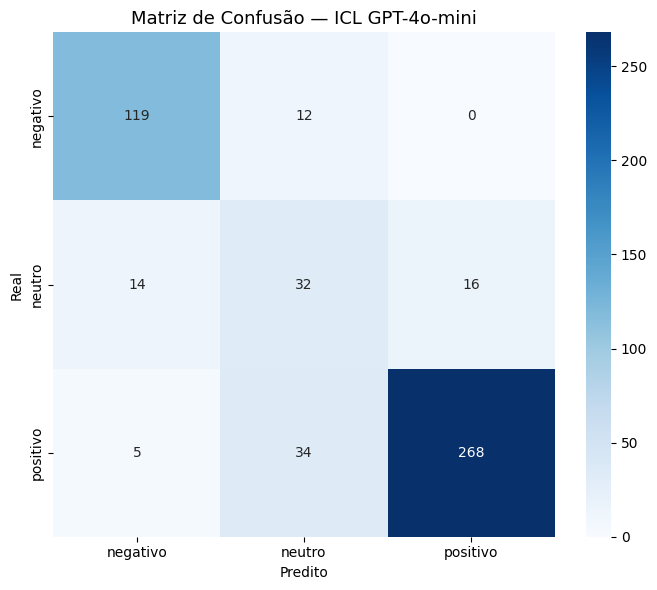

In [10]:
fig = plotar_matriz_confusao(y_true, y_pred, "ICL GPT-4o-mini")
plt.show()

## 7. Análise de Custo

In [11]:
# Estimativa de custo (GPT-4o-mini pricing)
# Input: ~$0.15/MTok, Output: ~$0.60/MTok
tokens_input_estimado = ICL_SUBSET_SIZE * 800  # ~800 tokens por prompt
tokens_output_estimado = ICL_SUBSET_SIZE * 5   # ~5 tokens por resposta

custo_input = (tokens_input_estimado / 1_000_000) * 0.15
custo_output = (tokens_output_estimado / 1_000_000) * 0.60
custo_total = custo_input + custo_output

print(f"Tokens input estimado: {tokens_input_estimado:,}")
print(f"Tokens output estimado: {tokens_output_estimado:,}")
print(f"Custo estimado: ${custo_total:.4f}")

Tokens input estimado: 400,000
Tokens output estimado: 2,500
Custo estimado: $0.0615


## Resumo

- ICL few-shot com GPT-4o-mini em subset de 500 amostras
- 6 exemplos few-shot (2 por classe)
- Sem treinamento — apenas inferência via API
- Métricas salvas para comparação final
- Próximo passo: **07_comparacao_final.ipynb**